## Introduction

Let's analyze the Youtube trending videos using SQL. Data is automatically inserted into MySQL by AWS Lambda Function every day. Please check README.md for more details.

## Import libraries

In [1]:
import pandas as pd
import mysql.connector
import os
import warnings
warnings.filterwarnings(action="ignore")

# settings of pandas
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000 
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100

## Connect to AWS MySQL

In [3]:
# Create a connection to the database
def get_connection():
    try:
        # Get credentials from environment variables
        USER = os.environ["db_user"]
        PWD = os.environ["db_password"]
        HOST = os.environ["db_host"]
        PORT = os.environ["db_port"]
        DATABASE = os.environ["database"] 
        
        conn = mysql.connector.connect(
            host=HOST,
            database=DATABASE,
            port=PORT,
            user=USER,
            password=PWD
        )

        # Check if the connection was successful
        if conn.is_connected():
            print('Connected to AWS MySQL database')

    except mysql.connector.Error as e:
        print('Error connecting to AWS MySQL database: {}'.format(e))

    return conn

connection = get_connection()

Connected to AWS MySQL database


## Tables and schemas

In [4]:
query = """
    SELECT table_name
    FROM information_schema.tables 
    WHERE table_name LIKE 'trending_%'
"""
tables = pd.read_sql(query, connection)
tables

,TABLE_NAME
0,trending_record
1,trending_video
2,trending_video_channel


- `trending_record`: the records of trending videos, new records will be inserted daily
- `trending_video`: various attributes of trending videos
- `trending_video_channel`: channel information of trending videos

**trending_record**

In [5]:
query_record = """
    SHOW COLUMNS
    FROM trending_record
"""
record_cols = pd.read_sql(query_record, connection)
record_cols

,Field,Type,Null,Key,Default,Extra
0,id,int,NO,PRI,None,auto_increment
1,video_id,varchar(255),YES,MUL,None,
2,channel_id,varchar(255),YES,MUL,None,
3,rank,int,YES,,None,
4,views_millions,"decimal(10,2)",YES,,None,
5,extracted_at,timestamp,YES,,None,


**trending_video**

In [6]:
query_video = """
    SHOW COLUMNS
    FROM trending_video
"""
video_cols = pd.read_sql(query_video, connection)
video_cols

,Field,Type,Null,Key,Default,Extra
0,id,int,NO,PRI,None,auto_increment
1,video_id,varchar(255),YES,UNI,None,
2,title,varchar(255),YES,,None,
3,duration_sec,"decimal(10,1)",YES,,None,
4,tags,varchar(255),YES,,None,
5,category,varchar(255),YES,,None,
6,published_at,timestamp,YES,,None,


**trending_video_channel**

In [7]:
query_channel = """
    SHOW COLUMNS
    FROM trending_video_channel
"""
channel_cols = pd.read_sql(query_channel, connection)
channel_cols

,Field,Type,Null,Key,Default,Extra
0,id,int,NO,PRI,None,auto_increment
1,channel_id,varchar(255),YES,UNI,None,
2,channel_title,varchar(255),YES,,None,
3,custom_url,varchar(255),YES,,None,
4,country,varchar(255),YES,,None,
5,published_at,timestamp,YES,,None,


## Descriptive statistics

### Data duration

In [8]:
query = """
    SELECT min(extracted_at) AS from_date, 
           max(extracted_at) AS to_date
    FROM trending_record r
"""
min_max_records = pd.read_sql(query, connection)
min_max_records

,from_date,to_date
0,2022-08-20 17:58:27,2023-03-29 18:00:04


Data has collected since 2022-08-20 till now (2023-03-29), more than 7 months.

### Total number of videos and channels

In [9]:
query = """
    SELECT COUNT(DISTINCT video_id) video_count
    FROM trending_video
"""
cnt_videos = pd.read_sql(query, connection)
cnt_videos

,video_count
0,6452


In [10]:
query = """
    SELECT COUNT(DISTINCT channel_id) channel_count
    FROM trending_video_channel
"""
cnt_channels = pd.read_sql(query, connection)
cnt_channels

,channel_count
0,2451


## Country list

In [11]:
query = """
    SELECT country, 
           COUNT(DISTINCT channel_id) AS channel_count
    FROM trending_video_channel
    WHERE country <> ""
    GROUP BY 1
    ORDER BY 2 DESC
"""
cnt_country = pd.read_sql(query, connection)
cnt_country

,country,channel_count
0,US,1420
1,GB,193
2,CA,89
3,AU,54
4,KR,44
5,JP,23
6,IN,18
7,MX,12
8,IE,12
9,SE,10


**US** had the most trending videos, followed by **GB** (United Kingdom).

### Median duration of videos

Some videos might have hours while the others might have just a few minutes, what's the median duration in seconds?

In [12]:
query = """
    WITH cte AS (
    SELECT video_id, 
           duration_sec, 
           ROW_NUMBER() OVER (ORDER BY duration_sec) AS rnk, 
           COUNT(video_id) OVER () AS cnt
    FROM gans.trending_video
    )

    select ROUND(AVG(duration_sec), 0) AS median_duration_sec
    FROM cte
    WHERE rnk IN (cnt/2, cnt/2+1)
"""

median_duration = pd.read_sql(query, connection)
median_duration

,median_duration_sec
0,648.0


The median duration is 648 seconds, i.e., 10 min 48 seconds.

### Average days in trending

In [13]:
query = """
    WITH occur_days AS (
        SELECT video_id, count(*) AS occurence
        FROM trending_record r
        GROUP BY 1
    )
    
    SELECT ROUND(AVG(occurence), 2) AS avg_occur_days
    FROM occur_days;

"""
avg_days = pd.read_sql(query, connection)
avg_days

,avg_occur_days
0,2.81


Trending videos stayed on the trending list for an average of 2.8 days.

## List the top 10 most viewed videos

Among those trending videos, which are most viewed when in trending?

In [14]:
query = """
    SELECT r.video_id, 
           v.title, 
           MAX(views_millions) as max_view_millions
    FROM trending_record r
    JOIN trending_video v
    ON r.video_id = v.video_id
    GROUP BY 1,2
    ORDER BY 3 DESC
    LIMIT 10
"""
top_videos = pd.read_sql(query, connection)
top_videos

,video_id,title,max_view_millions
0,CocEMWdc7Ck,SHAKIRA || BZRP Music Sessions #53,264.84
1,jZGpkLElSu8,"KAROL G, Shakira - TQG (Official Video)",263.72
2,gQlMMD8auMs,BLACKPINK - ‘Pink Venom’ M/V,256.86
3,G7KNmW9a75Y,Miley Cyrus - Flowers (Official Video),180.72
4,POe9SOEKotk,BLACKPINK - ‘Shut Down’ M/V,145.90
5,TJ2ifmkGGus,"1,000 Blind People See For The First Time",109.07
6,HjBo--1n8lI,Rihanna’s FULL Apple Music Super Bowl LVII Halftime Show,91.90
7,j5y6xLpRwx4,"Shakira, Ozuna - Monotonía (Official Video)",86.46
8,YLt73w6criQ,I Paid A Real Assassin To Try To Kill Me,81.24
9,0CTp1a-aCUM,"100 Kids Vs 100 Adults For $500,000",79.12


The video "SHAKIRA || BZRP Music Sessions #53" had the most # of views, 264.84 million, in its last day as trending videos.

## List the top 10 videos by number of occurrences in trending

In [15]:
query = """
    SELECT r.video_id, 
           v.title, 
           count(DISTINCT extracted_at) as occur_days
    FROM trending_record r
    JOIN trending_video v
    ON r.video_id = v.video_id
    GROUP BY 1,2
    ORDER BY 3 DESC
    LIMIT 10
"""
top_freq_videos = pd.read_sql(query, connection)
top_freq_videos

,video_id,title,occur_days
0,G7KNmW9a75Y,Miley Cyrus - Flowers (Official Video),26
1,jZGpkLElSu8,"KAROL G, Shakira - TQG (Official Video)",25
2,CocEMWdc7Ck,SHAKIRA || BZRP Music Sessions #53,24
3,zwa7NzNBQig,"GloRilla, Cardi B - Tomorrow 2 (Official Music Video)",23
4,gG3516BF5_w,Carin Leon x Grupo Frontera - Que Vuelvas (Video Oficial),22
5,CnT6NRiTz9M,Lil Durk - Hanging With Wolves (Official Video),21
6,CtpdMkKvB6U,"hi, I'm Dream.",21
7,7IKab3HcfFk,I Survived 50 Hours In Antarctica,21
8,oftolPu9qp4,"PinkPantheress, Ice Spice - Boy’s a liar Pt. 2 (Official Video)",20
9,0-wPm99PF9U,The Little Mermaid | Official Teaser Trailer,20


Many of them contain "official" in titles. The video "Miley Cyrus - Flowers (Official Video)" appeared on Trending Videos for 26 days, the longest since 2022 August.

## List the top 10 videos by daily views increase

In [16]:
days_views_query = """
    SELECT r.video_id,
           v.title,
           COUNT(DISTINCT extracted_at) AS occur_days, 
           MAX(views_millions) - MIN(views_millions) AS views_millions_increased,
           ROUND((MAX(views_millions) - MIN(views_millions))/(COUNT(*) - 1), 2) AS avg_daily_views_millions_increased
    FROM trending_record r
    JOIN trending_video v
    ON v.video_id = r.video_id
    GROUP BY 1, 2
    ORDER BY 5 DESC
    LIMIT 10
"""

top_daily_increase_videos =  pd.read_sql(days_views_query, connection)
top_daily_increase_videos

,video_id,title,occur_days,views_millions_increased,avg_daily_views_millions_increased
0,FRilMXZqNhA,NCT 127 엔시티 127 '질주 (2 Baddies)' MV,6,55.98,11.20
1,jZGpkLElSu8,"KAROL G, Shakira - TQG (Official Video)",25,249.10,10.38
2,pG6iaOMV46I,IVE 아이브 'Kitsch' MV,3,20.19,10.10
3,CocEMWdc7Ck,SHAKIRA || BZRP Music Sessions #53,24,229.54,9.98
4,SxHmoifp0oQ,STAYC(스테이씨) 'Teddy Bear' MV,2,9.43,9.43
5,zugAhfd2r0g,ITZY “Cheshire” M/V @ITZY,5,35.99,9.00
6,zkvIzKwzYNc,Kep1er 케플러 | ‘We Fresh' M/V,2,8.59,8.59
7,selkk5MpGVo,THE BOYZ(더보이즈) ‘ROAR’ MV,2,8.34,8.34
8,gQlMMD8auMs,BLACKPINK - ‘Pink Venom’ M/V,18,139.23,8.19
9,F0B7HDiY-10,IVE 아이브 'After LIKE' MV,9,61.57,7.70


Those videos are all music related (with **MV** in title).

The biggest increase in daily views was from video "NCT 127 엔시티 127 '질주 (2 Baddies)' MV", which gained about 11.2 million views per day when it was trending.

## List the top 10 channels by number of trending videos

In [17]:
query = """
    SELECT r.channel_id, 
           c.channel_title,
           c.published_at,
           COUNT(DISTINCT r.video_id) as trending_videos_num
    FROM trending_record r
    JOIN trending_video_channel c
    ON r.channel_id = c.channel_id
    GROUP BY 1,2,3
    ORDER BY 4 DESC
    LIMIT 10
"""
top_channels = pd.read_sql(query, connection)
top_channels

,channel_id,channel_title,published_at,trending_videos_num
0,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,2014-12-13 19:07:35,96
1,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,2005-11-20 18:20:33,33
2,UCooTLkxcpnTNx6vfOovfBFA,FOX Soccer,2006-03-30 11:58:55,28
3,UCqFzWxSCi39LnW1JKFR3efg,Saturday Night Live,2013-07-23 14:32:27,19
4,UCUaT_39o1x6qWjz7K2pWcgw,Beast Reacts,2016-04-24 13:43:46,17
5,UCLXzq85ijg2LwJWFrz4pkmw,Skip and Shannon: UNDISPUTED,2016-08-17 08:45:48,16
6,UC3sznuotAs2ohg_U__Jzj_Q,The Film Theorists,2014-05-12 12:36:31,16
7,UCiYcA0gJzg855iSKMrX3oHg,CoryxKenshin,2009-04-26 20:32:20,16
8,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,2014-02-28 14:48:23,15
9,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,2008-01-25 00:45:44,15


The top three channels are all related to ball games.

The #1 channel is **NFL** with 96 trending videos. That's almost 3 times as much as the second-ranked channel **NBA**.

## Popular categories

Each video has a category, which categories have the most trending videos?

In [18]:
query = """
    SELECT category, 
           count(*) as video_count
    FROM trending_video
    GROUP BY 1
    ORDER BY 2 DESC
"""
top_cates = pd.read_sql(query, connection)
top_cates

,category,video_count
0,Gaming,1362
1,Entertainment,1286
2,Music,973
3,Sports,815
4,People & Blogs,536
5,Comedy,293
6,Film & Animation,257
7,News & Politics,232
8,Science & Technology,188
9,Education,172


**Gaming**, **Entertainment**, and **Music** are the top 3 most popular categories among trending videos.

## Popular tags

Each video has multiple tags, which tags are most popular among trending videos?

Before counting videos by tag, we will need a recursive CTE to split string of tags to tag per row. Then let's get the list of the top 20 most used tags.

In [19]:
cte_tags = """
    -- split string of tags to single tag per row
    
    WITH RECURSIVE cte_tags AS (
        SELECT video_id,
               category,
               SUBSTRING_INDEX(tags, ',', 1) AS tag,
               SUBSTRING(tags, LENGTH(SUBSTRING_INDEX(tags, ',', 1))+2) AS remaining_tags
        FROM trending_video
        WHERE tags <> ''
        UNION ALL
        SELECT video_id,
               category,
               SUBSTRING_INDEX(remaining_tags, ',', 1) AS tag,
               SUBSTRING(remaining_tags, LENGTH(SUBSTRING_INDEX(remaining_tags, ',', 1))+2) AS remaining_tags
        FROM cte_tags
        WHERE remaining_tags <> ''
    )
"""
query = """
    -- select top 20 most used tags
    
    SELECT tag,
           count(DISTINCT video_id) as video_count
    FROM cte_tags
    WHERE tag <> ''
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
"""
top_tags = pd.read_sql(cte_tags + query, connection)
top_tags

,tag,video_count
0,funny,380
1,minecraft,270
2,comedy,257
3,challenge,158
4,vlog,139
5,sports,127
6,rap,125
7,gaming,125
8,nba,121
9,gameplay,110


The most popular tag is "funny", which is used by 380 trending videos. Interestingly, the 2nd most popular tag is "minecraft", which should belong to "Gaming" category, but tag "gaming" is only applied to 125 videos.

What other tags are used for the "Gaming" category?


## Top 20 most popular tags of gaming videos

In [20]:
query_gaming_tags = """
    SELECT tag,
           count(DISTINCT video_id) as video_count
    FROM cte_tags
    WHERE tag <> ''
        AND category = "Gaming"
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
"""
top_gaming_tags = pd.read_sql(cte_tags + query_gaming_tags, connection)
top_gaming_tags

,tag,video_count
0,minecraft,251
1,funny,109
2,gameplay,105
3,gaming,99
4,pokemon,85
5,challenge,74
6,fortnite,65
7,nintendo,60
8,Game,57
9,minecraft hardcore,51


According to those popular tags in Gaming videos, **minecraft** was most common among trending gaming videos, **pokemon** was also a popular theme.

## Tags of top 20 most viewed Science & Technology videos

I'm curious about the category Science & Technology.
We know it ranked 9th by number of trending videos, obviously it's far less popular than Gaming. But there are still 188 trending videos in the past 7 months, what are they about?

We might know the answer by checking their tags.

In [21]:
query = """
    -- Top 20 most viewed science & technology videos
    
    , top_tech_videos AS (
        SELECT r.video_id, 
               v.title, 
               MAX(views_millions) as max_view_millions
        FROM trending_record r
        JOIN trending_video v
        ON r.video_id = v.video_id
        WHERE v.category = "Science & Technology"
        GROUP BY 1,2
        ORDER BY 3 DESC
        LIMIT 20
    )
    
    -- Select tags have more than 1 occurence
    
    SELECT tag,
           COUNT(DISTINCT v.video_id) as video_count
    FROM top_tech_videos v
    JOIN cte_tags t
        ON t.video_id = v.video_id
    WHERE tag <> ''
    GROUP BY 1
    HAVING COUNT(DISTINCT v.video_id) > 1
    ORDER BY 2 DESC
"""

tags_top_tech_videos = pd.read_sql(cte_tags + query, connection)
tags_top_tech_videos

,tag,video_count
0,iPhone 14 Pro,5
1,iPhone 14,4
2,Apple,3
3,Dynamic Island,3
4,iPhone 14 Pro Max,3
5,iPhone,3
6,iPhone 14 Plus,3
7,SOS via satellite,2
8,48MP quad pixel,2
9,Samsung,2


In the past 7 months, most trending science & technology videos are mobile phone related, more specifically, **iPhone 14** related.

## Trends of categories

Monthly number of videos indicates the popularity of categories. How did the popularity of each category change over time? Let's ignore August 2022 as data was collected from 08/20.

In [22]:
query = """
    SELECT category, 
           DATE_FORMAT(extracted_at, "%Y-%m") as date,
           count(DISTINCT v.video_id) as video_count
    FROM trending_video v
    JOIN trending_record r
        ON r.video_id = v.video_id
    WHERE DATE_FORMAT(extracted_at, "%Y-%m") > "2022-08"
    GROUP BY 1, 2
    ORDER BY 2, 3 DESC
"""
monthly_cate_cnt = pd.read_sql(query, connection)
monthly_cate_cnt

,category,date,video_count
0,Gaming,2022-09,212
1,Entertainment,2022-09,183
2,Music,2022-09,161
3,Sports,2022-09,121
4,People & Blogs,2022-09,93
5,News & Politics,2022-09,45
6,Science & Technology,2022-09,44
7,Film & Animation,2022-09,37
8,Comedy,2022-09,32
9,Education,2022-09,26


With the help of `seaborn` library, we can plot the trend of each category.

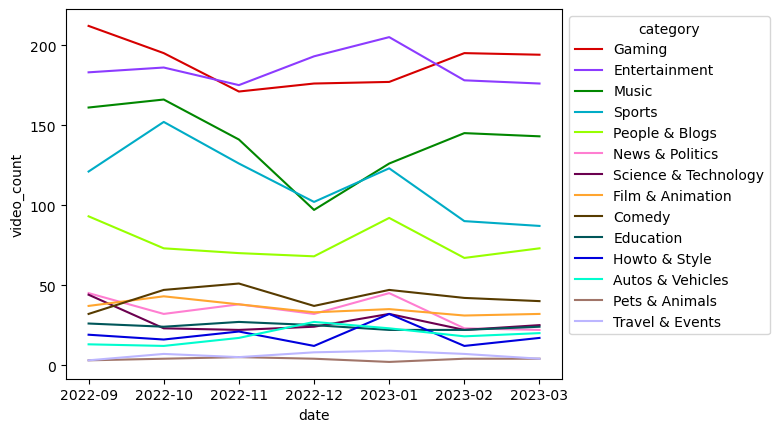

In [23]:
import seaborn as sns
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=15)

ax = sns.lineplot(data=monthly_cate_cnt, x="date", y="video_count", hue="category", palette=palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

The rankings for the top five most popular categories are relatively stable, though there seem to be some cyclical shifts. In Q4 2022, the number of music and sports trending videos decreased significantly. We need to wait for more data to see if there are any seasonal patterns.